# Demo

This notebook is a demonstrative example of the Urban Density Mapping project. Successes and shortcomings are better discussed in the partial and final reports.

###  Libraries and Functions
The main library used was numpy and matplotlib, but other were used punctually. Some functions available on the course [github](https://github.com/maponti/imageprocessing_course_icmc) were also used.

In [2]:
import numpy as np
import imageio
import csv
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.color import rgb2hsv,hsv2rgb
import pandas as pd

In [4]:
def histogram(A, no_levels):
    # gets the size of the input matrix
    N, M = A.shape
    hist = np.zeros(no_levels).astype(int)
    for i in range(no_levels):
        
        pixels_value_i = np.where(A == i)
        hist[i] = pixels_value_i[0].shape[0]
            
    return(hist)

def histogram_equalization(A, no_levels):
    hist = histogram(A,  no_levels)
    
    histC = np.zeros(no_levels).astype(int)

    histC[0] = hist[0] 
    for i in range(1,  no_levels):
        histC[i] = hist[i] + histC[i-1]

    hist_transform = np.zeros(no_levels).astype(np.uint8)
    N, M = A.shape
    A_eq = np.zeros([N,M]).astype(np.uint8)
    
    
    for r in range(no_levels):
        s = ((no_levels-1)/float(M*N))*histC[r]
        A_eq[ np.where(A == r) ] = s
    
    return A_eq

In [41]:
# nomalize numpy ndarray to [0,2^8-1]
def normalize(matrix):
    max = np.amax(matrix)
    min = np.amin(matrix)
    matrix = (matrix - min) / (max - min)
    matrix *= ((2**8)-1)

    return matrix

def normalize01(matrix):
    max = np.amax(matrix)
    min = np.amin(matrix)
    matrix = (matrix - min) / (max - min)

    return matrix

### Sampled Image
The images were took out of Google Earth for the sake of simplicity. In this demo, a aerial view of Santos (and São Vicente, with a little bit of Praia Grande) will be used.

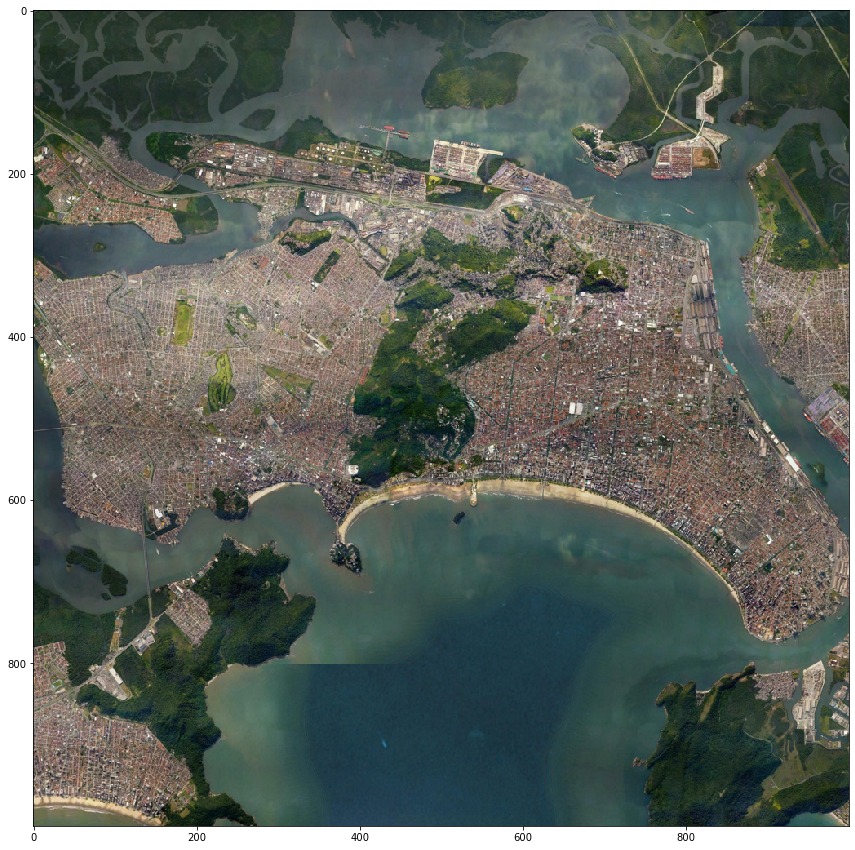

In [16]:
img = imageio.imread('PNGimages/santos.png')
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show()

### Extended Red Index and Thresholding
The extended red image is a kind of channel arithmetic based on vegetation indices. It attempts to lower the influence of Green and Blue channels and amplify of the Red.

In [6]:
# function to enhance city areas based on a extended red index
def exr_city(img):
    
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    #normalize channels
    r = r.astype(float)
    g = g.astype(float)
    b = b.astype(float)
    R = r/abs(r+g+b+10)
    G = g/abs(r+g+b+10)
    B = b/abs(r+g+b+10)
    
    # get extended red index image
    ExR = 3.5*R - 1.5*B - 2.5*G
    ExR = normalize(ExR).astype(np.uint8)
    exr_t = np.mean(ExR)

    # threshold for unintended area removal then equalize it
    tExR = np.where(ExR<1.05*exr_t, 0, ExR + 20)
    tExR = histogram_equalization(tExR,256)    
    tExR = normalize(tExR).astype(np.uint8)

    return tExR

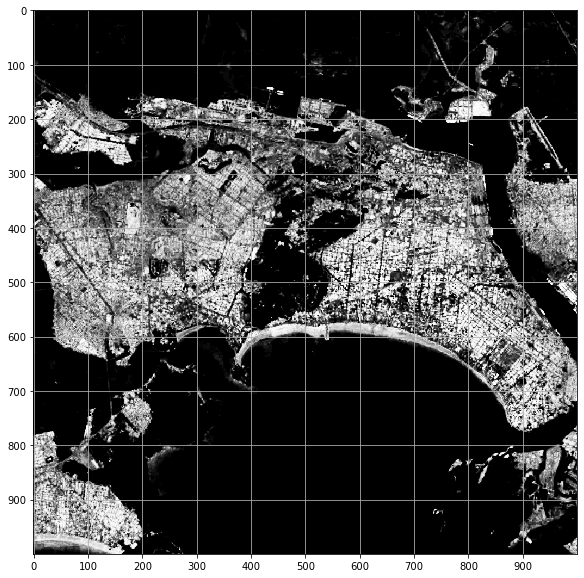

In [21]:
exr_img = exr_city(img)
plt.figure(figsize=(10,10))
plt.grid(True)
plt.xticks(np.arange(0,1100, step=100))
plt.yticks(np.arange(0,1100, step=100))
plt.imshow(exr_img , cmap='gray')
plt.show()

In [13]:
# get reference histograms
def hist_25intervals(A, no_levels):
    # gets the size of the input matrix
    #returns percentage of intensities in 25 evenly spaced intervals
    inter = no_levels/25.0
    A_alt = (A.flatten()/inter).astype(int)
    hist = np.zeros(25).astype(int)
    for i in range(25):
        
        pixels_value_i = np.where(A_alt==i)
        hist[i] = pixels_value_i[0].shape[0]
    hist = hist/np.sum(hist)
            
    return(hist)

def mean_hist25(exr_list,cord):
    
    hist_vet = np.zeros((100,100,25))
    ref_hist = np.zeros((8,25))
    for img in range(len(cord)):
        A = exr_list[img]
        ci,cj = cord[img]
        for i in range(100):
            for j in range(100):
                xi = ci+ i
                xj = cj+ j
                B = A[xi-2:xi+2, xj-2:xj+2]
                hist_vet[i,j] = hist_25intervals(B,256)
        for i in range(25):
            ref_hist[img,i] = np.mean(hist_vet[:,:,i])
    
    return ref_hist


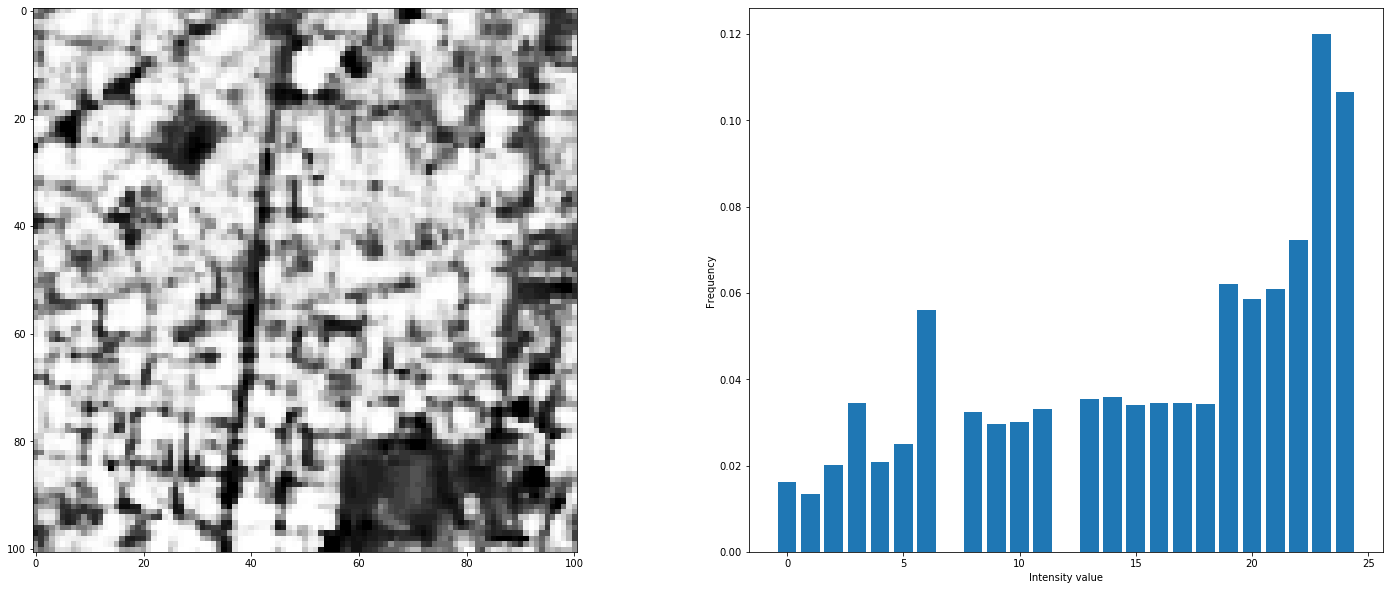

In [36]:
# Select square with coordinates
dense = exr_img[400:501, 600:701]
hist_dense = hist_25intervals(dense, 256)

plt.figure(figsize=(25,10))
plt.subplot(121)
plt.imshow(dense , cmap='gray')
plt.subplot(122)
plt.bar(range(25), hist_dense);
plt.xlabel('Intensity value');
plt.ylabel('Frequency');

In [14]:
# function for histogram comparisson
#http://blog.datadive.net/histogram-intersection-for-change-detection/

def hist25_comp(ref,test):
    
    ratio = 0
    for i in range(25):
        ratio += min(ref[i],test[i])
    
    return ratio

# function to run over image, enhancing pixels by histogram comparisson
def hist_enhance(exr_img, ref_hist):
    
    pad_img = np.pad(exr_img,2,'constant')
    
    hist_heat = np.zeros(exr_img.shape)
    for i in range(exr_img.shape[0]):
        for j in range(exr_img.shape[1]):
            xi = i + 2
            xj = j + 2
            B = pad_img[xi-2:xi+2, xj-2:xj+2]
            hist = hist_25intervals(B,256)
            h_comp =hist25_comp(ref_hist, hist) 
            
            if(h_comp >= 0.8):
                hist_heat[i,j] = 1.0
            elif(h_comp >= 0.3 and h_comp<0.8):
                hist_heat[i,j] = h_comp + 0.1
            else:
                hist_heat[i,j] = h_comp
    
    return hist_heat

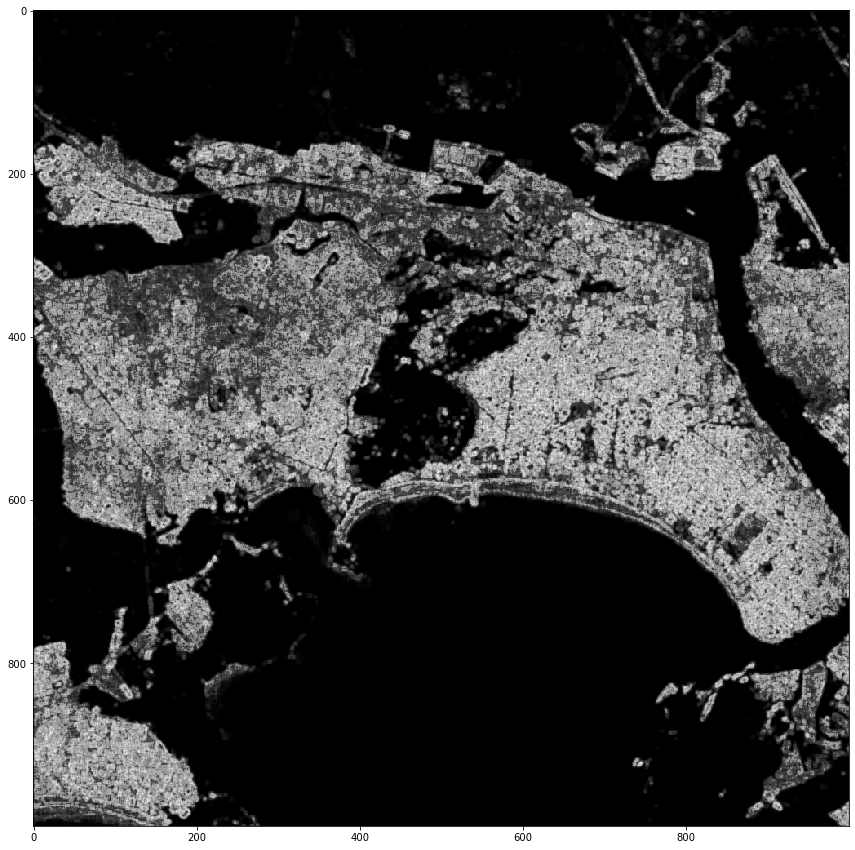

In [38]:
heat_mask = hist_enhance(exr_img, hist_dense)
plt.figure(figsize=(15,15))
plt.imshow(heat_mask, cmap='gray')
plt.show()

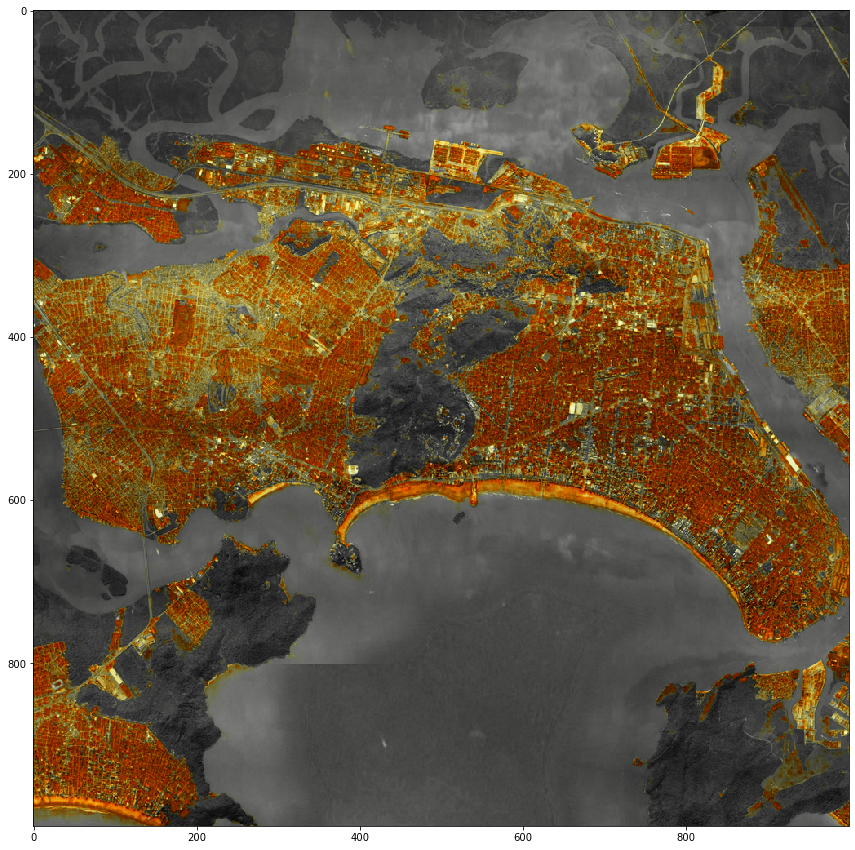

In [69]:
norm_exr = normalize01(exr_img)

hsv = rgb2hsv(img)
hsv[:,:,0] = 0.2 - heat_mask/10.0 - norm_exr/10.0
hsv[:,:,1] = np.where(norm_exr + heat_mask >1.0, 1.0, norm_exr + heat_mask)
tint_img = hsv2rgb(hsv)

plt.figure(figsize=(15,15))
plt.imshow(tint_img)

The results weren't really accurate, but good for a simple purpose. Maybe other visual indices should be combined and texture detection properly applied to render a more precise representation of the urban area.